In [1]:
import numpy as np
from PIL import Image
import time
import math
from PIL import Image 
from numba import cuda, float32
import time

Time taken (global): 1.053 seconds


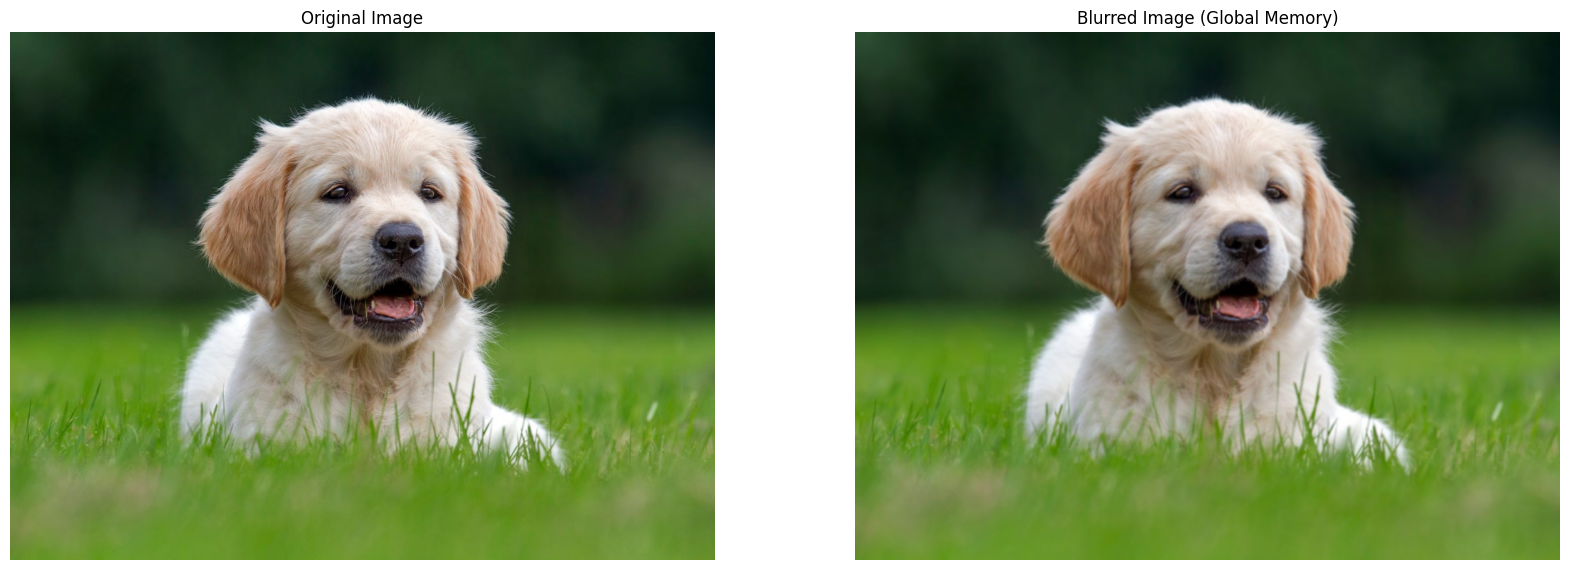

In [ ]:
kernel_vals = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)

kernel_vals /= np.sum(kernel_vals)
kernel_gpu = cuda.to_device(kernel_vals)
KERNEL_SIZE = 7
RADIUS = KERNEL_SIZE // 2

img_path = '../images/dog.jpg'
img = np.array(Image.open(img_path).convert('RGB'), dtype=np.float32)

@cuda.jit
def gaussian_blur_global(src, dst, kernel, ksize, radius):
    x, y = cuda.grid(2)
    if x >= src.shape[0] or y >= src.shape[1]:
        return

    acc_r = 0.0
    acc_g = 0.0
    acc_b = 0.0

    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            nx = min(max(x + i, 0), src.shape[0] - 1)
            ny = min(max(y + j, 0), src.shape[1] - 1)
            w = kernel[i + radius, j + radius]

            acc_r += src[nx, ny, 0] * w
            acc_g += src[nx, ny, 1] * w
            acc_b += src[nx, ny, 2] * w

    dst[x, y, 0] = acc_r
    dst[x, y, 1] = acc_g
    dst[x, y, 2] = acc_b



threadsperblock = (32, 32)
blockspergrid_x = (img.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (img.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
img_gpu = cuda.to_device(img)
out_gpu = cuda.device_array_like(img_gpu)
gaussian_blur_global[blockspergrid, threadsperblock](img_gpu, out_gpu, kernel_gpu, KERNEL_SIZE, RADIUS)
cuda.synchronize()
dat = out_gpu.copy_to_host()
end = time.time() - start

dat = np.clip(dat, 0, 255).astype(np.uint8)
Image.fromarray(dat).save('dog_blur_non_shared.png')
print(f"Time taken (global): {end:.3f} seconds")

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Blurred Image (Global Memory)')
plt.imshow(dat)
plt.axis('off')
plt.show()


Time taken (global): 0.732 seconds


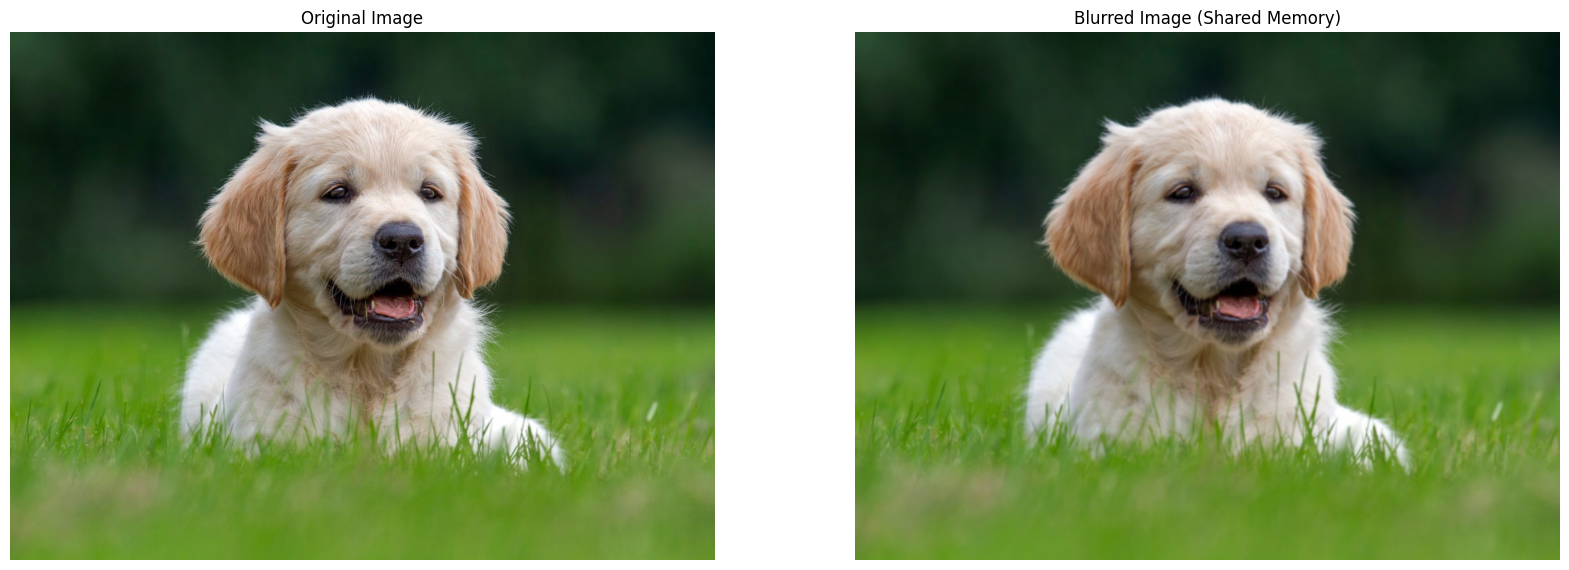

In [ ]:
kernel_vals = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)

kernel_vals /= np.sum(kernel_vals)
kernel_gpu = cuda.to_device(kernel_vals)
KERNEL_SIZE = 7
RADIUS = KERNEL_SIZE // 2

img_path = '../images/dog.jpg'
img = np.array(Image.open(img_path).convert('RGB'), dtype=np.float32)

@cuda.jit
def gaussian_blur_shared(src, dst, kernel, ksize, radius):
    shared = cuda.shared.array((32 + 6, 32 + 6, 3), float32)
    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    x, y = cuda.grid(2)
    block_x, block_y = cuda.blockIdx.x, cuda.blockIdx.y
    bdx, bdy = cuda.blockDim.x, cuda.blockDim.y

    for c in range(3):
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1): 
                sx = tx + radius + dx
                sy = ty + radius + dy
                gx = min(max(block_x * bdx + tx + dx, 0), src.shape[0] - 1)
                gy = min(max(block_y * bdy + ty + dy, 0), src.shape[1] - 1)
                shared[sx, sy, c] = src[gx, gy, c]

    cuda.syncthreads()

    if x < src.shape[0] and y < src.shape[1]:
        acc_r = acc_g = acc_b = 0.0
        for i in range(-radius, radius + 1):
            for j in range(-radius, radius + 1):
                w = kernel[i + radius, j + radius]
                acc_r += shared[tx + radius + i, ty + radius + j, 0] * w
                acc_g += shared[tx + radius + i, ty + radius + j, 1] * w
                acc_b += shared[tx + radius + i, ty + radius + j, 2] * w
        dst[x, y, 0] = acc_r
        dst[x, y, 1] = acc_g
        dst[x, y, 2] = acc_b



threadsperblock = (32, 32)
blockspergrid_x = (img.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (img.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
img_gpu = cuda.to_device(img)
out_gpu = cuda.device_array_like(img_gpu)
gaussian_blur_shared[blockspergrid, threadsperblock](img_gpu, out_gpu, kernel_gpu, KERNEL_SIZE, RADIUS)
cuda.synchronize()
dat = out_gpu.copy_to_host()
end = time.time() - start

dat = np.clip(dat, 0, 255).astype(np.uint8)
Image.fromarray(dat).save('dog_blur_shared.png')
print(f"Time taken (global): {end:.3f} seconds")


import matplotlib.pyplot as plt
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Blurred Image (Shared Memory)')
plt.imshow(dat)
plt.axis('off')
plt.show()


#### Bigger image

/home/tung/novete36/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:938: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


Time taken (global): 2.320 seconds


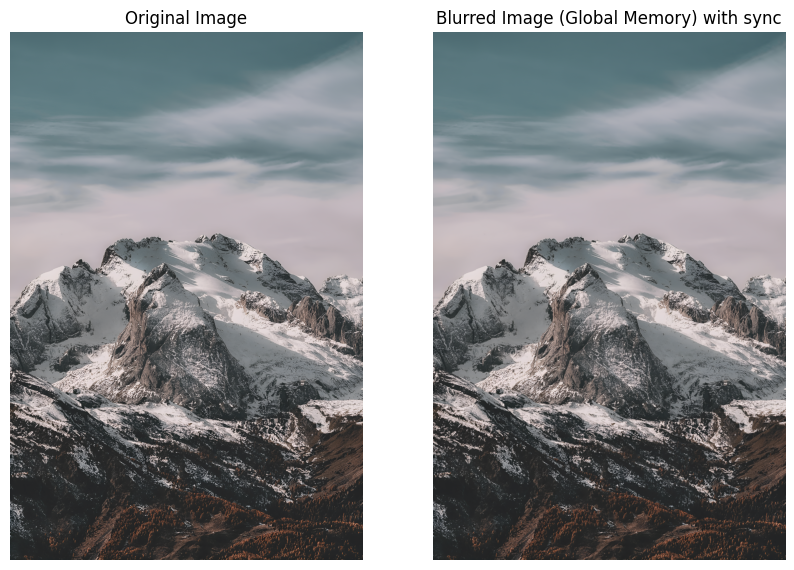

In [2]:
kernel_vals = np.array([
    [0, 0, 1, 2, 1, 0, 0],
    [0, 3, 13, 22, 13, 3, 0],
    [1, 13, 59, 97, 59, 13, 1],
    [2, 22, 97, 159, 97, 22, 2],
    [1, 13, 59, 97, 59, 13, 1],
    [0, 3, 13, 22, 13, 3, 0],
    [0, 0, 1, 2, 1, 0, 0]
], dtype=np.float32)


img_path = '../images/8k.jpg'
img = np.array(Image.open(img_path).convert('RGB'), dtype=np.float32)


threadsperblock = (32, 32)
blockspergrid_x = (img.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (img.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

img_path = '../images/8k.jpg'
img = np.array(Image.open(img_path).convert('RGB'), dtype=np.float32)


kernel_vals /= np.sum(kernel_vals)
kernel_gpu = kernel_vals
KERNEL_SIZE = 7
RADIUS = KERNEL_SIZE // 2   

@cuda.jit
def gaussian_blur_global(src, dst, kernel, ksize, radius):
    x, y = cuda.grid(2)
    if x >= src.shape[0] or y >= src.shape[1]:
        return

    acc_r = 0.0
    acc_g = 0.0
    acc_b = 0.0

    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            nx = min(max(x + i, 0), src.shape[0] - 1)
            ny = min(max(y + j, 0), src.shape[1] - 1)
            w = kernel[i + radius, j + radius]

            acc_r += src[nx, ny, 0] * w
            acc_g += src[nx, ny, 1] * w
            acc_b += src[nx, ny, 2] * w

    dst[x, y, 0] = acc_r
    dst[x, y, 1] = acc_g
    dst[x, y, 2] = acc_b

start = time.time()
img_gpu = cuda.to_device(img)
out_gpu = cuda.device_array_like(img_gpu)
gaussian_blur_global[blockspergrid, threadsperblock](img_gpu, out_gpu, kernel_gpu, KERNEL_SIZE, RADIUS)
cuda.synchronize()
dat = out_gpu.copy_to_host()
end = time.time() - start


print(f"Time taken (global): {end:.3f} seconds")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Blurred Image (Global Memory) with sync')
plt.imshow(dat.astype(np.uint8))
plt.axis('off')
plt.show()


Time taken (shared): 0.871 seconds


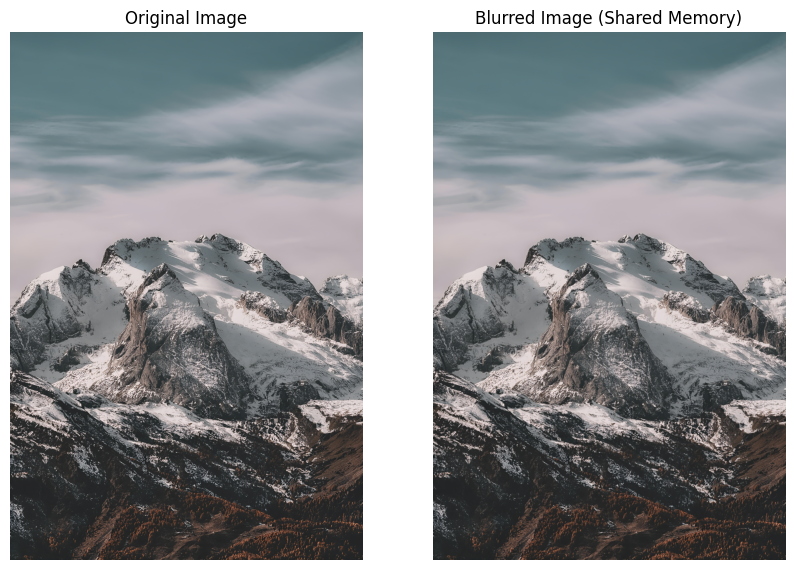

In [3]:
kernel_gpu = cuda.to_device(kernel_vals)
@cuda.jit
def gaussian_blur_shared(src, dst, kernel, ksize, radius):
    shared = cuda.shared.array((32 + 6, 32 + 6, 3), float32)
    tx, ty = cuda.threadIdx.x, cuda.threadIdx.y
    x, y = cuda.grid(2)
    block_x, block_y = cuda.blockIdx.x, cuda.blockIdx.y
    bdx, bdy = cuda.blockDim.x, cuda.blockDim.y

    for c in range(3):
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1): 
                sx = tx + radius + dx
                sy = ty + radius + dy
                gx = min(max(block_x * bdx + tx + dx, 0), src.shape[0] - 1)
                gy = min(max(block_y * bdy + ty + dy, 0), src.shape[1] - 1)
                shared[sx, sy, c] = src[gx, gy, c]

    cuda.syncthreads()

    if x < src.shape[0] and y < src.shape[1]:
        acc_r = acc_g = acc_b = 0.0
        for i in range(-radius, radius + 1):
            for j in range(-radius, radius + 1):
                w = kernel[i + radius, j + radius]
                acc_r += shared[tx + radius + i, ty + radius + j, 0] * w
                acc_g += shared[tx + radius + i, ty + radius + j, 1] * w
                acc_b += shared[tx + radius + i, ty + radius + j, 2] * w
        dst[x, y, 0] = acc_r
        dst[x, y, 1] = acc_g
        dst[x, y, 2] = acc_b



threadsperblock = (32, 32)
blockspergrid_x = (img.shape[0] + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (img.shape[1] + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

start = time.time()
img_gpu = cuda.to_device(img)
out_gpu = cuda.device_array_like(img_gpu)
gaussian_blur_shared[blockspergrid, threadsperblock](img_gpu, out_gpu, kernel_gpu, KERNEL_SIZE, RADIUS)
cuda.synchronize()
dat = out_gpu.copy_to_host()
end = time.time() - start

print(f"Time taken (shared): {end:.3f} seconds")
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Blurred Image (Shared Memory)')
plt.imshow(dat.astype(np.uint8))
plt.axis('off')
plt.show()